## Importing Libraries

In [84]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import color
import cv2

## Read Input

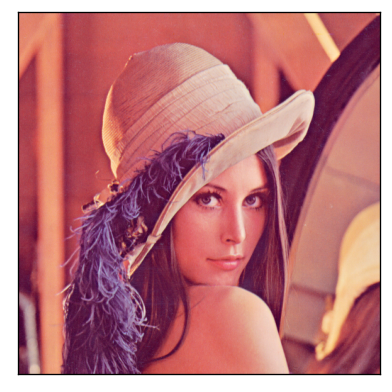

In [5]:
def show_image(img, title='', save=False, name='', ticks=True):
    '''
    a function for showing images
    '''
    plt.figure(dpi=120)
    plt.imshow(img, cmap='gray')
    if ticks:
        plt.xticks([])
        plt.yticks([])
    plt.title(title)
    if save:
        iio.imwrite(name, img)
    plt.show()
    
img = iio.imread('im05.png')
show_image(img)

## Calculate Centers

In [75]:
def scale(img):
    return np.uint8((img-np.min(img))/(np.max(img)-np.min(img))*255)

def init_center(img, k):
    centers = []
    x, y, c = img.shape
    x0, y0 = x//np.sqrt(k), y//np.sqrt(k)
    x1, y1 = x0//2, y0//2
    while x1 <= x:
        y1 = y0 // 2
        while y1 <= y:
            centers.append((x1, y1))
            y1 += y0
        x1 += x0
    gradx = ndimage.sobel(img, axis=0, mode='constant')
    grady = ndimage.sobel(img, axis=1, mode='constant')
    grad = np.abs(gradx) + np.abs(grady)
    grad = np.mean(grad, axis=2)
    for ind, center in enumerate(centers):
        center = int(center[0]), int(center[1])
        a = np.mean(img[center[0]-2:center[0]+3, center[1]-2:center[1]+3, :], axis=2)
        index = np.unravel_index(np.argmin(a, axis=None), a.shape)
        center = (center[0]-2+index[0], center[1]-2+index[1])
        grad[center[0]-2:center[0]+3, center[1]-2:center[1]+3] =  0
        centers[ind] = center
    return centers

## Assignment

In [82]:
def assignment(img, k):
    
    img_lab = color.rgb2lab(img)
    def dist(img, p1, p2, alpha=0.6):
        dlab = np.sqrt(np.sum((img[p1[0],p1[1],:]-img[p2[0],p2[1],:])**2))
        dxy = np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
        return dlab + alpha*dxy
    
    def stop(c0, c, k):
        err = 0
        for i in range(k):
            p0 = c0[i]
            p = c[i]
            err += (p[0]-p0[0])**2+(p[1]-p0[1])**2
        return np.sqrt(err)
    centers = init_center(img, k)
    S = int(np.sqrt(img.size/k/3))
    l = -np.ones((img.shape[0], img.shape[1]))
    d = 10**10*np.ones((img.shape[0], img.shape[1]))
    for ind, center in enumerate(centers):
        l[center] = ind
        d[center] = 0
    centers0 = [(10**3,10**3)]*k
    while stop(centers0, centers, k) >= 10:
        for ind, center in enumerate(centers):
            for i in range(center[0]-S, center[0]+S):
                for j in range(center[1]-S, center[1]+S):
                    if i>=0 and j>=0 and i<img.shape[0] and j<img.shape[1]:
                        D = dist(img_lab, center, (i, j))
                        if D < d[i, j]:
                            d[i, j] = D
                            l[i, j] = ind
        centers0 = centers.copy()
        centers = [(0, 0)]*k
        num = [0]*k
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                centers[int(l[i, j])] = (centers[int(l[i, j])][0]+i, centers[int(l[i, j])][1]+j)
                num[int(l[i, j])] += 1
        for i in range(k):
            a = centers[i][0] // num[i]
            b = centers[i][1] // num[i]
            centers[i] = (a, b)
    
    show_image(scale(l))
    return d, l, centers

## Image After Mean

In [100]:
def superpixel_mean(img, l, centers, k):
    img = np.float32(img)
    ls = [[]]*k
    r = [0]*k
    g = [0]*k
    b = [0]*k
    red = np.zeros((img.shape[0], img.shape[1]))
    green = np.zeros((img.shape[0], img.shape[1]))
    blue = np.zeros((img.shape[0], img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ls[int(l[i, j])].append((i, j))
    for i in range(k):
        r[i] = int(img[centers[i][0], centers[i][1], 0])
        g[i] = int(img[centers[i][0], centers[i][1], 1])
        b[i] = int(img[centers[i][0], centers[i][1], 2])
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            red[i, j] = r[int(l[i, j])]
            green[i, j] = g[int(l[i, j])]
            blue[i, j] = b[int(l[i, j])]
    red = scale(red)
    green = scale(green)
    blue = scale(blue)
    rgb = np.dstack((red, green, blue))
    show_image(rgb)
    return rgb

## $k=64$

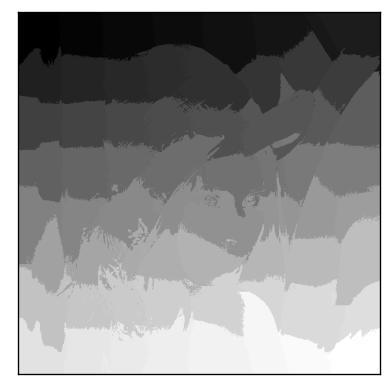

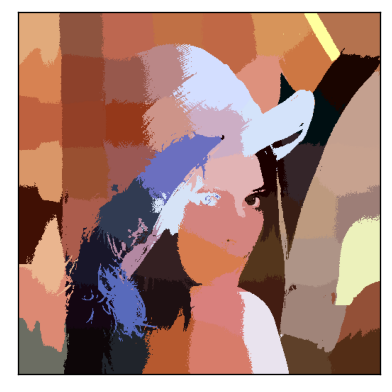

In [108]:
d, l, centers = assignment(img, 64)
sup = superpixel_mean(img, l, centers, 64)

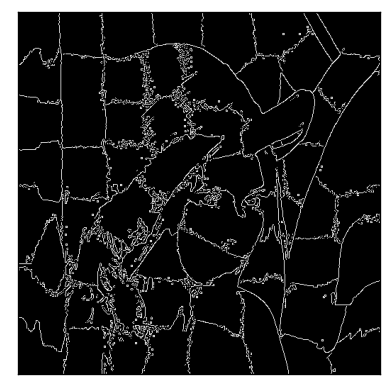

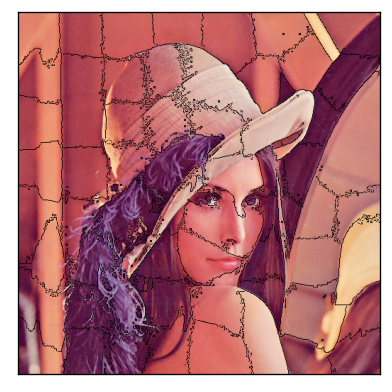

In [115]:
edge = cv2.Canny(sup, 30, 40)
show_image(edge)
out = img.copy()
for i in range(edge.shape[0]):
    for j in range(edge.shape[1]):
        if edge[i,j] == 255:
            out[i,j,:] = 0
show_image(out)

## $k=256$

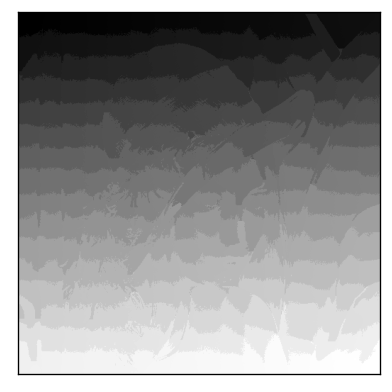

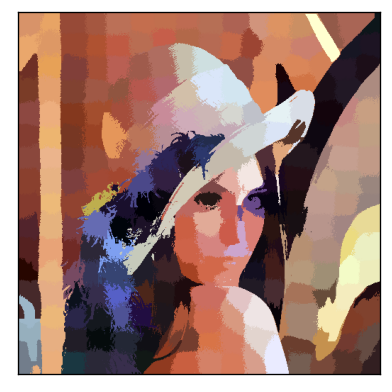

In [116]:
d, l, centers = assignment(img, 256)
sup = superpixel_mean(img, l, centers, 256)

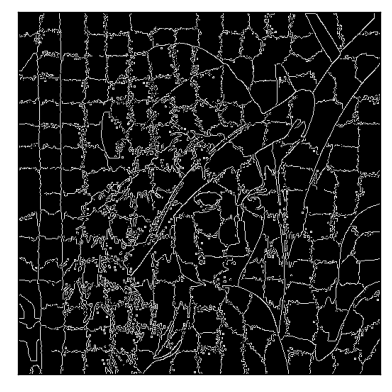

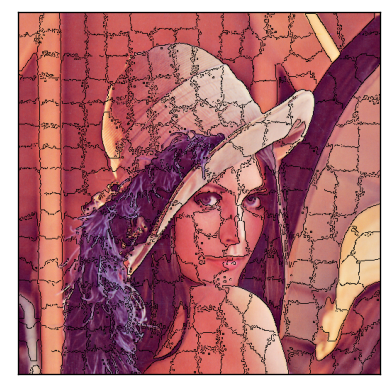

In [118]:
edge = cv2.Canny(sup, 25, 40)
show_image(edge)
out = img.copy()
for i in range(edge.shape[0]):
    for j in range(edge.shape[1]):
        if edge[i,j] == 255:
            out[i,j,:] = 0
show_image(out)

## $k=1024$

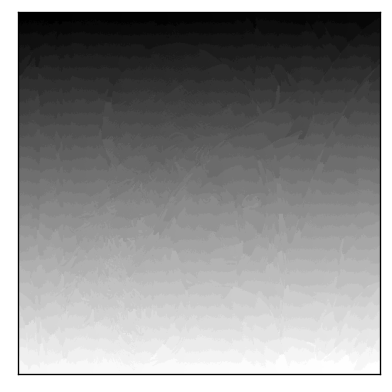

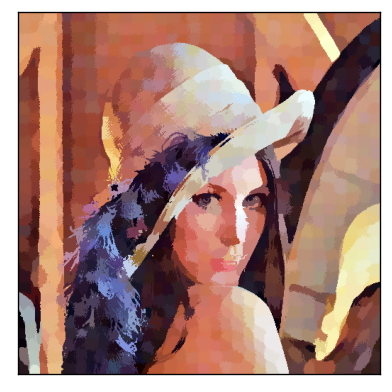

In [119]:
d, l, centers = assignment(img, 1024)
sup = superpixel_mean(img, l, centers, 1024)

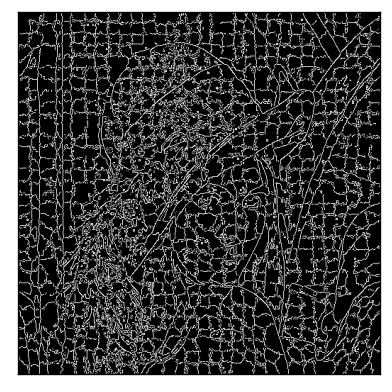

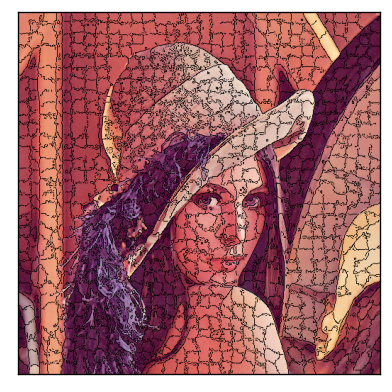

In [126]:
edge = cv2.Canny(sup, 20, 30)
show_image(edge)
out = img.copy()
for i in range(edge.shape[0]):
    for j in range(edge.shape[1]):
        if edge[i,j] == 255:
            out[i,j,:] = 0
show_image(out)

## $k=4096$

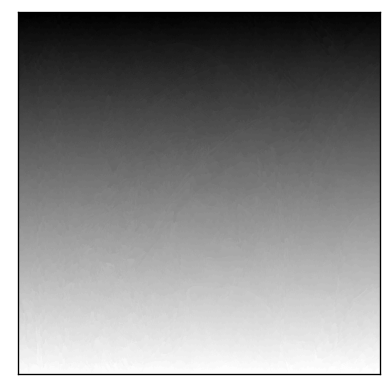

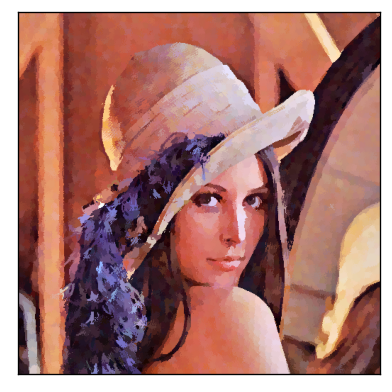

In [101]:
d, l, centers = assignment(img, 4096)
sup = superpixel_mean(img, l, centers, 4096)

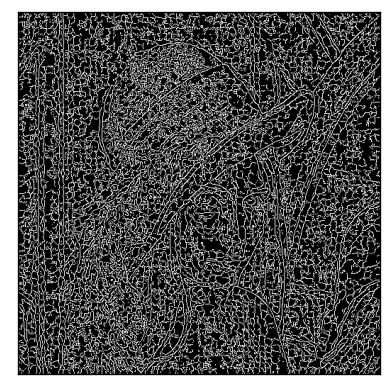

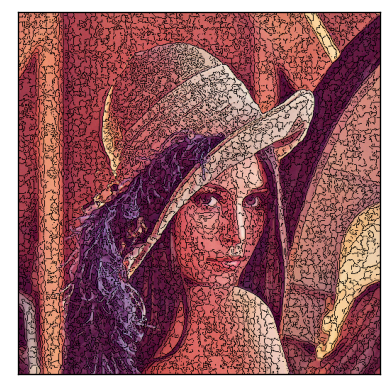

In [106]:
edge = cv2.Canny(sup, 25, 35)
show_image(edge)
out = img.copy()
for i in range(edge.shape[0]):
    for j in range(edge.shape[1]):
        if edge[i,j] == 255:
            out[i,j,:] = 0
show_image(out)